In [3]:
%matplotlib inline
from __future__ import division
import numpy as np
import h5py
import os
import six
from six.moves import range
import itertools
import matplotlib.pyplot as plt
import PIL
from PIL import ImageOps
from PIL import ImageEnhance

In [4]:
h5py.version.version

'2.7.0'

In [5]:
data_dir = '../../data'
crop_size = (64, 48)

h5 = h5py.File(os.path.join(data_dir, 'train.hdf5'))

In [8]:
print("{:10}| {:10}| {:30}".format("name", "dtype", "shape"))
print("-" * 40)
for name, dset in h5.items():
    print("{:10}| {:10}| {:30}".format(name, str(dset.dtype), str(dset.shape)))

name      | dtype     | shape                         
----------------------------------------
image     | uint8     | (10770, 60, 80)               
speed     | float32   | (10770, 1)                    
steering  | float32   | (10770, 1)                    
timestamp | float64   | (10770, 1)                    


In [9]:
def data_generator(batch_size=128, n_epoch=-1):
    n = len(h5['image'])
    idx = np.arange(n)
    np.random.shuffle(idx)
    n_batches = n // batch_size
    if n_epoch == -1:
        n_epoch = 1000000000
    for epoch in range(n_epoch):
        for b in range(0, n, batch_size):
            batch_idx = np.sort(idx[b:b+batch_size])
            yield {
                'image': h5['image'][batch_idx, :, :],
                'steering': h5['steering'][batch_idx, :],
                'speed': h5['speed'][batch_idx, :],
            }
    
batch = next(data_generator())

In [10]:
batch['image'].min(), batch['image'].max(), 

(15, 203)

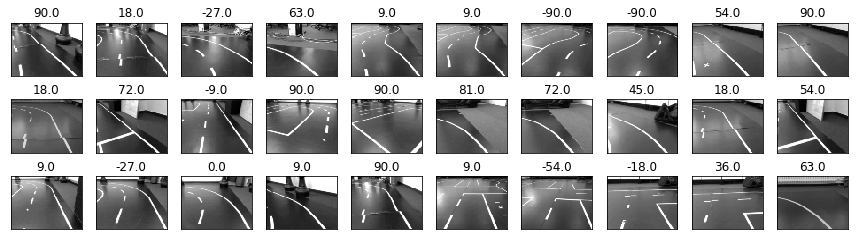

In [11]:
fig, axes = plt.subplots(3, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.set_title("{:.1f}".format(float(180 / np.pi * batch['steering'][i])))
    ax.imshow(batch['image'][i], cmap='gray')
    ax.grid('off')
    ax.set_xticks([])
    ax.set_yticks([])

#### number of seconds per epoch

In [12]:
%%timeit -n 3

for batch in data_generator(n_epoch=1):
    pass

3 loops, best of 3: 6.49 s per loop


In [21]:
batch = next(data_generator())

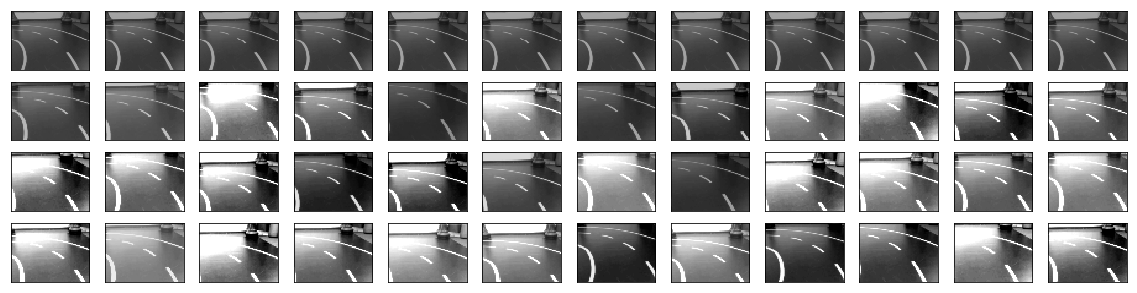

In [22]:
def augment_img(img):
    width, height = img.size
    max_crop_left = img.size[0] - crop_size[0]
    max_crop_upper = img.size[1] - crop_size[1]
    left = np.random.choice(max_crop_left)
    upper = np.random.choice(max_crop_upper)
    img = img.crop([left, upper, left + crop_size[0], upper + crop_size[1]])
                    #width - left, height - upper])
    brightness = ImageEnhance.Brightness(img)

    img = brightness.enhance(np.random.uniform(0.75, 2.5))
    contrast = ImageEnhance.Contrast(img)
    img = contrast.enhance(np.random.uniform(0.75, 2.5))
    return img

images = [PIL.Image.fromarray(x) for x in batch["image"]]
img = images[0]
fig, axes = plt.subplots(4, 12, figsize=(20, 5))

for ax in axes[:1].flat:
    ax.imshow(np.array(img), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])
for ax in axes[1:].flat:
    ax.imshow(np.array(augment_img(img)), cmap='gray', vmin=0, vmax=255)
    ax.set_xticks([])
    ax.set_yticks([])

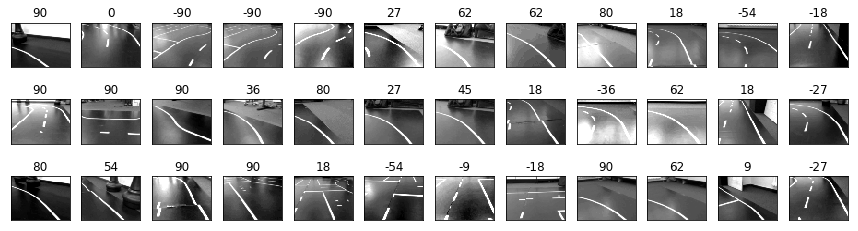

In [15]:
def augment_batch(batch):
    images = [PIL.Image.fromarray(x) for x in batch["image"]]
    images = [augment_img(img) for img in images]
    batch_aug = {'images': np.stack([np.array(img) for img in images])}
    for k, v in batch.items():
        if k != 'images':
            batch_aug[k] = v
    return batch_aug

batch_aug = augment_batch(batch)

fig, axes = plt.subplots(3, 12, figsize=(15, 4))

for ax, img, steering in zip(axes.flat, batch_aug['images'], batch_aug['steering']):
    ax.imshow((img), cmap='gray')
    ax.set_title("{:}".format(int(180*float(steering) / np.pi)))
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
def batch_to_numpy(batch):
    return 2.* batch['images'] / 255. - 1, batch['steering']

X, y = batch_to_numpy(batch_aug)
print("data: {}, labels: {}".format(X.shape, y.shape))
print("data max: {}, data min: {}".format(X.max(), X.min()))
print("labels max: {}, labels min: {}".format(y.max(), y.min()))